# Acting Career Overview

In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import glob
import itertools
import re

In total, Robert Pattinson has acted in 38 movies.

In [184]:
df_info = pd.read_csv('movie_info.csv')
df_info.shape

(38, 7)

The Year is int64 instead of date.

The Meta_score is object instead of float.

In [183]:
# Drop the useless column
df_info.drop(['Unnamed: 0'],axis = 1, inplace = True)

# Check feature types
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Name        38 non-null     object 
 1   Year        38 non-null     int64  
 2   Genres      38 non-null     object 
 3   Cast        38 non-null     object 
 4   Rating      38 non-null     float64
 5   Meta_score  38 non-null     object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.9+ KB


## 1. Movie Amount Throughout the Years

On average, Robert Pattinson acts in 2 movie per year.

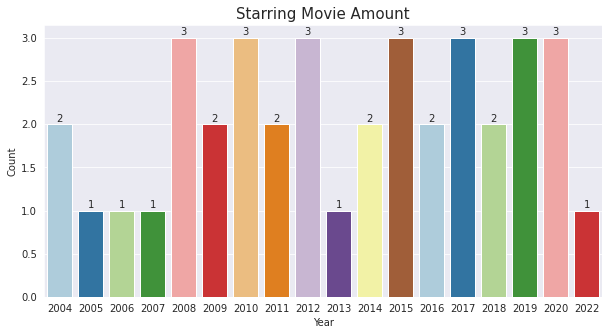

In [53]:
year_gp = df_info.groupby(['Year']).size().reset_index(name = 'Count')
plt.figure(figsize = (10,5))
ax = sns.barplot(x = "Year", y = 'Count', data = year_gp, palette = 'Paired')

for p in ax.patches:
  amount = f'{p.get_height():.0f}\n'
  x = p.get_x() + p.get_width() / 2
  y = p.get_height()
  ax.annotate(amount, (x,y), ha = 'center', va = 'center')

ax.set_title("Starring Movie Amount", fontsize = 15)
ax.set_xlabel("Year")

plt.show()

In [59]:
year_gp['Count'].describe()

count    18.000000
mean      2.111111
std       0.832352
min       1.000000
25%       1.250000
50%       2.000000
75%       3.000000
max       3.000000
Name: Count, dtype: float64

## 2. Role Type

Robert Pattinson stars in movie as a Leading Role in 79% of total movies.

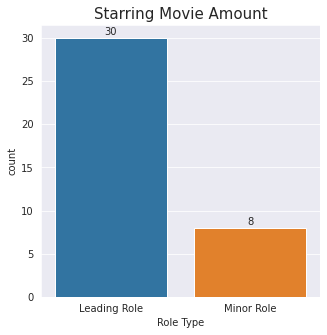

In [63]:
role = []
for stars in df_info['Cast']:
  if 'Robert Pattinson' in stars:
    role.append("Leading Role")
  else:
    role.append("Minor Role")
role
plt.figure(figsize = (5,5))
df_info["Role"] = role
ax = sns.countplot(x=role)
for p in ax.patches:
  amount = f'{p.get_height():.0f}\n'
  x = p.get_x() + p.get_width() / 2
  y = p.get_height()
  ax.annotate(amount, (x,y), ha = 'center', va = 'center')

ax.set_title("Starring Movie Amount", fontsize = 15)
ax.set_xlabel("Role Type")

plt.show()

## 3. Role Type Throughout Time

With his experience accumulates, he leads the movie more and more often.

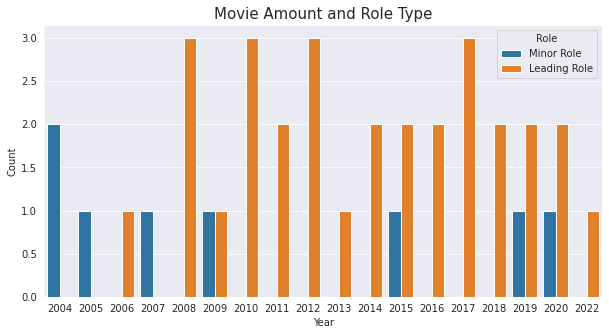

In [68]:
year_role_gp = df_info.groupby(['Year','Role']).size().reset_index(name = 'Count')
plt.figure(figsize = (10,5))
ax = sns.barplot(x = 'Year', y = 'Count', hue = 'Role', data = year_role_gp)
ax.set_title("Movie Amount and Role Type", fontsize = 15)
ax.set_xlabel("Year")
plt.show()

## 4. Audience Reviews vs Critics Reviews

Generally, critics would give a more harsh ratings compared to audiences.

(Notice: 3 old movies do not have the Meta Critics Score, so we set them as 0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


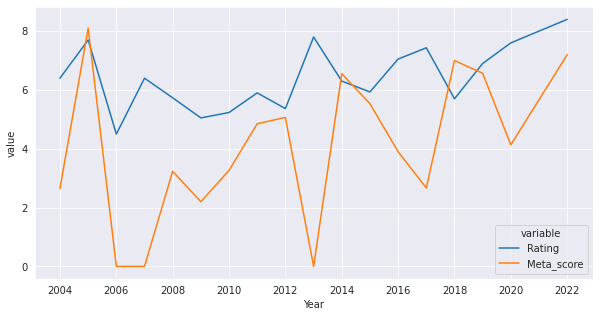

In [87]:
df_info["Meta_score"] = df_info["Meta_score"].replace("None", 0)
df_info["Meta_score"] = round(df_info["Meta_score"].astype("int") / 10,1)
df_melt = pd.melt(df_info, ['Name', 'Year', 'Genres', 'Cast', 'Role'])
df_melt['Year'] = pd.to_datetime(df_melt['Year'], format='%Y')
plt.figure(figsize = (10,5))
sns.lineplot('Year', 'value', hue = 'variable', data=df_melt, ci = None)

## 5. Sentiment of Each Movie

The following steps are to add the movie names to each of the movie sentiment file.

In [88]:
def unzip(file_name):
  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Done')

In [124]:
unzip('Movie_reviews_labeled.zip')

Done


In [127]:
path = r'Movie_reviews_labeled' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    name = []
    df = pd.read_csv(filename, index_col=None, header=0)
    for i in range(len(df)):
      movie = re.search(r'.*?\/(.*?)\.csv', filename).group(1)
      name.append(movie)
    df["Name"] = name
    li.append(df)
                      
Reviews = pd.concat(li, axis=0, ignore_index=True)

In [180]:
Reviews

,Unnamed: 0,Review Rating,Comment,Emotion,Name
1,1,3,This was a missed opportunity. RP is not well ...,negative,Dior: Dior Homme Intense City
2,2,8,"New York City, the city of a billion dreams an...",positive,Dior: Dior Homme Intense City
4,1,3,The movie works only as a metaphor of the univ...,negative,High Life
7,4,10,I always read the one star reviews first. This...,positive,High Life
8,5,10,I had to sit with this one for a few days afte...,positive,High Life
...,...,...,...,...,...
8055,34,8,I never thought much of Dean's acting ability ...,positive,Life
8056,35,5,"Dennis Stock, a photographer ready to take the...",negative,Life
8057,36,5,When I learnt this movie is about James Dean a...,negative,Life
8058,37,5,I can't stop thinking about the actor who play...,negative,Life


Pivot the dataframe so we can make stacked bar plot.

In [178]:
Reviews = Reviews.dropna()

emotion_gb = Reviews.groupby(['Name',"Emotion"]).size().reset_index(name = "Count")
emotion_gb = emotion_gb.pivot(index="Name", columns="Emotion", values="Count")
emotion_gb = emotion_gb.replace(np.nan, 0)
emotion_gb=emotion_gb.reset_index()
emotion_gb.head()

Emotion,Name,negative,positive
0,Bel Ami,22.0,22.0
1,Cosmopolis,103.0,67.0
2,Damsel,31.0,25.0
3,Dior: 1000 Lives - Dior Homme,0.0,1.0
4,Dior: Dior Homme Intense City,1.0,1.0


Even though Twilight is the movie made him famous overnight, it still cannot change its poor quality.

Even though Batman is going to be the most top rated movie considering the audience and critics rating trend, but actually the sentiment of audience indicate the opposite. Negative sentiment is high.

Text(0.5, 0, 'Count')

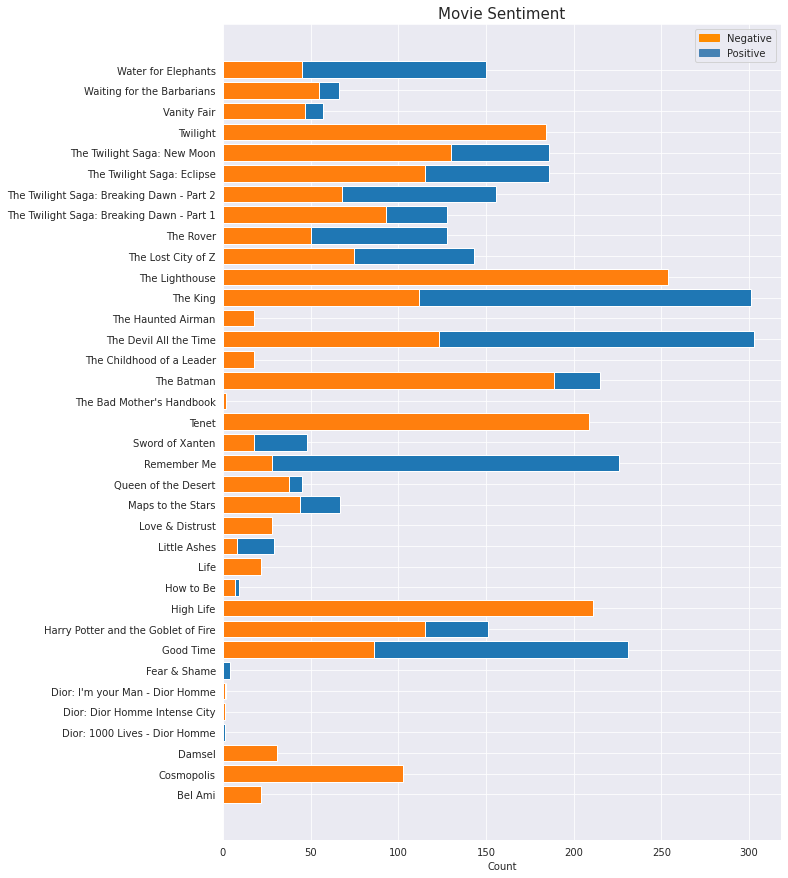

In [179]:
plt.figure(figsize = (10,15))
plt.barh(emotion_gb['Name'],emotion_gb['positive'])
plt.barh(emotion_gb['Name'],emotion_gb['negative'])

colors = {'Negative':'darkorange', 'Positive':'steelblue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.title("Movie Sentiment",fontsize = 15)
plt.xlabel("Count")